In [6]:
import numpy as np
import matplotlib.pyplot as pl
import projection
import numpy as np
import scipy.special as sp
import scipy.linalg as spla
import scipy.sparse as sparse
import scipy.integrate as integ
import matplotlib.pyplot as pl
import glob
import wavefront as wf
import uuid
from tqdm import tqdm, tqdm_notebook
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

# Metapupils and telescope footprint

Fluctuations in the refraction index of the atmosphere affects the propagation of light and produces what astronomers know as *seeing*. Under the geometric optics approximation, the phase of light $\phi$ at a given aperture is given by the integration of the phase perturbation along the whole atmosphere of height $H$:

$$
\phi(\mathbf{r},\boldsymbol{\theta}) = \int_0^H \phi(\mathbf{r}+h \boldsymbol{\theta}_k) \mathrm{d}h,
$$

where $\boldsymbol{\theta}$ indicates the direction at which we are observing and $\mathbf{r}$ is the vector position of a position in the telescope aperture. Assuming that there is a finite number $K$ of infinitely thin turbulence layers in the atmosphere, the previous integral can be written as a summation:

$$
\phi(\mathbf{r},\boldsymbol{\theta}) \approx \sum_{i=1}^K \phi_i(\mathbf{r}+h_i \boldsymbol{\theta}_k).
$$

The following figure displays the projection of the telescope entrance pupil on different layers in the atmosphere. It can be seen that these projections occupy only a portion of the field-of-view of the telescope or metapupil. Deformable mirrors (DMs) are only conjugated to a certain number of height layers, so that one expects that the full volume cannot be compensated for with the available DMs.

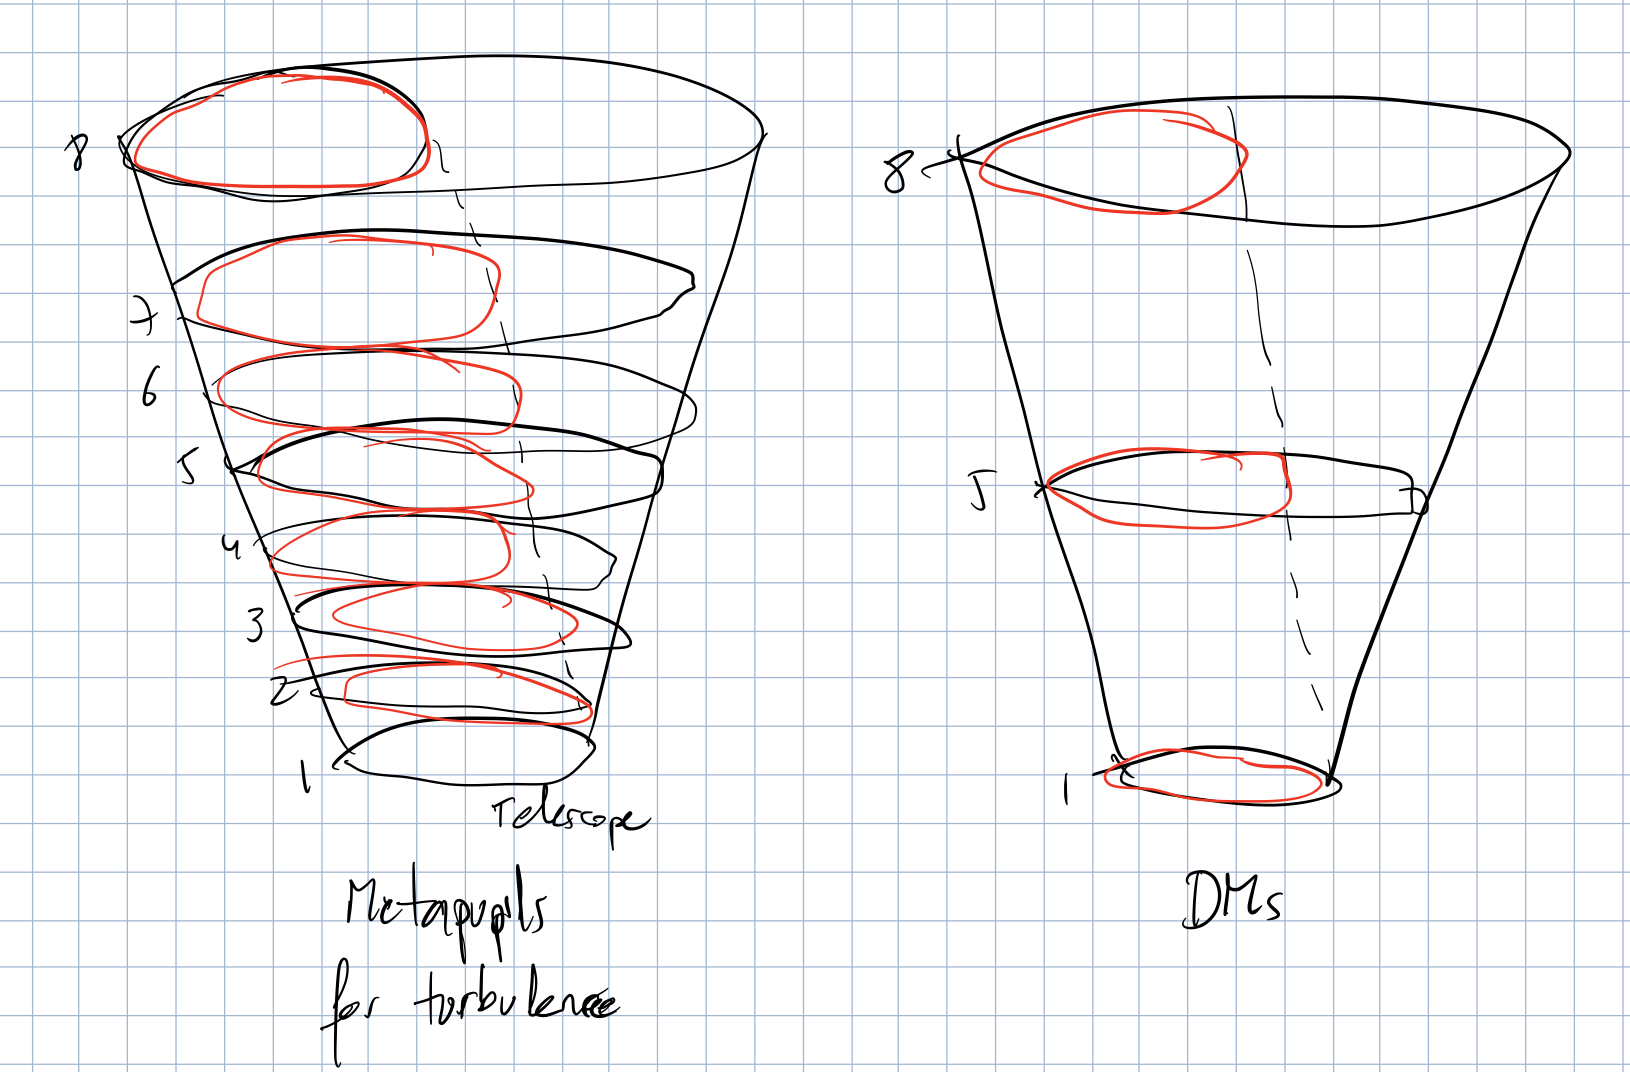

In [2]:
Image(filename="metapupil.png")

It was demonstrated by Ragazzoni et al. (1999) that if the phase in a given metapupil is written as a linear combination of Zernike functions as

$$
\phi_i(\mathrm{r}) = \sum_{k=1}^N \alpha_{ik} Z_k(\mathrm{r}),
$$

then the Zernike expansion of any circular part of the metapupil can be written again as a linear combination of Zernike functions, with the same upper $N$:

$$
\phi'_i(\mathrm{r}') = \sum_{k=1}^N \beta_{ik} Z_k(\mathrm{r}'),
$$

This means that both expansion coefficients can be related with a matrix, whose matrix elements can be obtained analytically or numerically by projection (e.g., Tatulli 2013):

$$
\boldsymbol{\beta} = \mathbf{M} \boldsymbol{\alpha}
$$

Given the previous relations, assume that we measure the wavefront towards a set of $M$ stars. Each wavefront is then projected over the Zernike orthogonal basis, so that each star $k$ provides an equation like:

$$
\phi_k = \sum_{i=1}^K \beta_{ik} Z_i(\mathrm{r}) = \sum_{i=1}^K \phi_i(\mathbf{r}+h_i \boldsymbol{\theta}_k) = \sum_{i=1}^K \sum_{k=1}^N \alpha_{ik} Z_k(\mathrm{r})
$$

If now we stack together all wavefronts observed for each star, we can write a linear system like:

$$
\left[ 
\begin{array}{c}
b_1^\mathrm{star\, 1} \\
b_2^\mathrm{star\, 1} \\
\vdots \\
b_1^\mathrm{star\, 2} \\
b_2^\mathrm{star\, 2} \\
\vdots \\
b_1^\mathrm{star\, K} \\
b_2^\mathrm{star\, K} \\
\end{array}
\right] = \left[
\begin{array}{cccc}
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \cdots \\
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star\, 1}\right] & \cdots \\
\cdots & \cdots & \cdots & \cdots \\
\left[ \mathbf{M}_\mathrm{h1}^\mathrm{star K}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star K}\right] & \left[ \mathbf{M}_\mathrm{h2}^\mathrm{star K}\right] & \cdots 
\end{array}
\right]
\left[
\begin{array}{c}
a_1^\mathrm{h1} \\
a_2^\mathrm{h1} \\
\vdots \\
a_1^\mathrm{h2} \\
a_2^\mathrm{h2} \\
\vdots \\
a_1^\mathrm{hK} \\
a_2^\mathrm{hK} \\
\end{array}
\right]
$$

where $a_i^\mathrm{hK}$ is the $i$-th Zernike coefficient of the expansion of the phase perturbation at height $K$, while $b_i^\mathrm{star\, K}$ is the measured $i$-th Zernike coefficient of the wavefront towards star $K$. The linear system matrix has dimensions $N_Z N_S \times N_Z N_H$, with $N_S$ the number of stars, $N_Z$ the number of Zernike coefficients to consider and $N_H$ the number of considered layers.

In [17]:
def even(x):
    return x%2 == 0

def nearest(array, value):
    return (np.abs(array-value)).argmin()

class tomography(object):
    """This class defines an atmosphere that can be used to generate synthetic MCAO observations
    and also apply different tomography schemes
    """
    def __init__(self, nStars, nZernike, fov, heights, DTel, wavelength=5000., verbose=True, numericalProjection=True, addPiston=False):
        """Class creation
        
        Args:
            nStars (int): number of stars used for the MCAO
            nZernike (int): maximum number of Zernike coefficients to use
            fov (float): field-of-view [arcsec]
            heights (float): array of heights to be used [km]
            DTel (float): telescope diameter [m]
            verbose (bool, optional): turn on verbosity
            numericalProjection (bool, optional): use the numerical approach for computing the projection matrix for the footprints
            addPiston (bool, optional): add piston mode
        """
        self.nHeight = len(heights)
        self.nStars = nStars
        self.nZernike = nZernike
        self.fov = fov / 206265.0        # in radians
        self.heights = heights * 1e3
        self.DTel = DTel
        self.verbose = verbose
        self.MComputed = False
        self.numericalProjection = numericalProjection
        self.addPiston = addPiston
        self.noll0 = 1
        self.wavelength = wavelength

        if (not self.addPiston):
            self.noll0 = 2

        self.DMetapupil = self.DTel + self.heights * self.fov

        self.t = np.zeros((self.nHeight,self.nStars))
        self.beta = np.zeros((self.nHeight,self.nStars))
        self.angle = np.zeros((self.nHeight,self.nStars))

        if (self.verbose):
            print("-------------------------------------------------------------------")
            print(" - Zernike modes: {0}".format(self.nZernike))
            print(" - Number of heights : {0} -> {1} km".format(self.nHeight, self.heights * 1e-3))
            print(" - FOV: {0} arcsec".format(206265.*self.fov))
            print(" - Number of stars : {0}".format(self.nStars))
            print("-------------------------------------------------------------------")

        for i in range(self.nHeight):            
            for j in range(self.nStars-1):
                self.t[i,j] = (self.heights[i] * self.fov) / self.DMetapupil[i]
                self.beta[i,j] = self.DMetapupil[i] / self.DTel
                self.angle[i,j] = j * 2.0 * np.pi / (self.nStars - 1.0)
            self.t[i,-1] = 0.0
            self.beta[i,-1] = self.DMetapupil[i] / self.DTel
            self.angle[i,-1] = 0.0
        
        if (self.projectionExists() == 0):
            if (self.verbose):
                print("Projection matrix does not exist")
            self.computeProjection()

        self.aStack = {}
        self.a = {}

# Read cn2 file
        cn2 = np.loadtxt('cn2.dat')

# Compute total r0 value in cm
        self.r0Reference = (0.423 * (2.0 * np.pi / (self.wavelength*1e-10))**2 * integ.trapz(cn2[:,1], x=cn2[:,0]))**(-3.0/5.0) * 1e2

        for i in range(len(self.heights)):
            indFrom = nearest(cn2[:,0] - cn2[0,0], self.heights[i])
            indTo = nearest(cn2[:,0] - cn2[0,0], self.heights[i]+500.0)+1
            # print(integ.trapz(cn2[indFrom:indTo,1], x=cn2[indFrom:indTo,0]) / integ.trapz(cn2[:,1], x=cn2[:,0]))
        # stop()

    def projectionExists(self):
        """Check whether a projection matrix exists
        
        Returns:
            bool: True/False
        """
        files = glob.glob('matrices/transformationMatrices*.npz')
        for f in files:
            out = np.load(f)
            heights = out['arr_1']
            nStars = out['arr_2']
            nZernike = out['arr_3']
            fov = out['arr_4']
            DTel = out['arr_5']
            ind = np.where(np.in1d(heights, self.heights))[0]
            if (len(ind) == self.nHeight):
                if (nStars == self.nStars and nZernike >= self.nZernike and 
                    fov == self.fov and DTel == self.DTel):
                    self.M = out['arr_0'][0:self.nZernike,0:self.nZernike,ind,:]
                    if (self.verbose):
                        print("Projection matrix exists : {0}".format(f))
                        print(" - Zernike modes: {0}".format(self.nZernike))
                        print(" - Number of heights : {0} -> {1} km".format(self.nHeight, self.heights * 1e-3))
                        print(" - FOV: {0} arcsec".format(206265.*self.fov))
                        print(" - Number of stars : {0}".format(self.nStars))
                        self.MComputed = True
                        self.stackProjection()
                    return True
                
        return False

    def plotPupils(self):
        """
        Plot the pupils                
        """
        ncols = int(np.ceil(np.sqrt(self.nHeight)))
        nrows = int(np.ceil(self.nHeight / ncols))
        cmap = pl.get_cmap('tab10')
        pl.close('all')

        f, ax = pl.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols,2*nrows))
        ax = ax.flatten()        
        for i in range(self.nHeight):
            radiusMetapupil = self.DMetapupil[i] / 2.0
            circle = pl.Circle((0,0), radiusMetapupil, fill=False, linewidth=2, axes=ax[i])
            ax[i].add_artist(circle)
            ax[i].set_xlim([-0.7*self.DMetapupil[i],0.7*self.DMetapupil[i]])
            ax[i].set_ylim([-0.7*self.DMetapupil[i],0.7*self.DMetapupil[i]])
            ax[i].set_title('h={0} km'.format(self.heights[i] / 1e3))
            for j in range(self.nStars):
                radiusCircle = radiusMetapupil / self.beta[i,j]
                xCircle = radiusMetapupil * self.t[i,j] * np.cos(self.angle[i,j])
                yCircle = radiusMetapupil * self.t[i,j] * np.sin(self.angle[i,j])
                circle = pl.Circle((xCircle,yCircle), radiusCircle, fill=False, axes=ax[i], linewidth=2, color=cmap(j/self.nStars))
                ax[i].add_artist(circle)

    def computeProjection(self):
        """
        Compute the projection matrix for the heights and number of stars defined
        
        Returns:
            None
        """
        if (not self.MComputed):
            self.M = np.zeros((self.nZernike,self.nZernike,self.nHeight,self.nStars))            
            for i in tqdm_notebook(range(self.nHeight), desc='Height'):                
                for j in tqdm_notebook(range(self.nStars), desc='Stars'):                    
                    if (self.numericalProjection):
                        self.M[:,:,i,j] = projection.zernikeProjectionMatrixNumerical(self.nZernike, self.beta[i,j], self.t[i,j], self.angle[i,j], verbose=True, radius=128, includePiston=False)
                    else:
                        self.M[:,:,i,j] = projection.zernikeProjectionMatrix(self.nZernike, self.beta[i,j], self.t[i,j], self.angle[i,j], verbose=True, includePiston=False)
            np.savez('matrices/transformationMatrices_{0}.npz'.format(uuid.uuid4()), self.M, self.heights, self.nStars, self.nZernike, self.fov, self.DTel)
            self.stackProjection()

    def stackProjection(self):
        """Stack the projection matrix to take all heights into account
        
        Returns:
            None
        """
        self.MStack = np.zeros((self.nZernike*self.nStars, self.nZernike*self.nHeight))
        for i in range(self.nHeight):
            for j in range(self.nStars):
                left = i*self.nZernike
                right = (i+1)*self.nZernike
                up = j*self.nZernike
                down = (j+1)*self.nZernike
                self.MStack[up:down,left:right] = self.M[:,:,i,j]

    def generateTurbulentZernikesKolmogorov(self, r0, keepOnly=None):
        """Generate the covariance matrix for the Zernike coefficients for a given value of r0 using Kolmogorov statistics
        
        Args:
            r0 (float): Fried radius [m]
        
        Returns:
            None
        """
        self.covariance = np.zeros((self.nZernike,self.nZernike))
        for i in range(self.nZernike):
            ni, mi = wf.nollIndices(i+self.noll0)
            for j in range(self.nZernike):
                nj, mj = wf.nollIndices(j+self.noll0)
                if (even(i - j)):
                    if (mi == mj):
                        phase = (-1.0)**(0.5*(ni+nj-2*mi))
                        t1 = np.sqrt((ni+1)*(nj+1)) * np.pi**(8.0/3.0) * 0.0072 * (self.DTel / r0)**(5.0/3.0)
                        t2 = sp.gamma(14./3.0) * sp.gamma(0.5*(ni+nj-5.0/3.0))
                        t3 = sp.gamma(0.5*(ni-nj+17.0/3.0)) * sp.gamma(0.5*(nj-ni+17.0/3.0)) * sp.gamma(0.5*(ni+nj+23.0/3.0))
                        self.covariance[i,j] = phase * t1 * t2 / t3

        self.a['Original'] = np.random.multivariate_normal(np.zeros(self.nZernike), self.covariance, size=(self.nHeight)).T

# Keep only the heights that we want
        if (keepOnly != None):
            for i in range(self.nHeight):
                if (self.heights[i]/1e3 not in keepOnly):
                    self.a['Original'][:,i] = 0.0

        self.aStack['Original'] = self.a['Original'].T.flatten()


    def generateTurbulentZernikesVonKarman(self, r0, L0):
        """Generate the covariance matrix for the Zernike coefficients for a given value of r0 using von Karman statistics
        
        Args:
            r0 (float): Fried radius [m]
            L0 (float): outer scale [m]
        
        Returns:
            None
        """
        self.covariance = np.zeros((self.nZernike,self.nZernike))
        for i in range(self.nZernike):
            ni, mi = wf.nollIndices(i+self.noll0)
            for j in range(self.nZernike):
                nj, mj = wf.nollIndices(j+self.noll0)
                if (even(i - j)):
                    if (mi == mj):
                        phase = (-1.0)**(0.5*(ni+nj-2*mi))
                        t1 = np.sqrt((ni+1)*(nj+1)) * np.pi**(8.0/3.0) * 1.16 * (self.DTel / r0)**(5.0/3.0)

                        for k in range(50):
                            phase2 = (-1.0)**k / np.math.factorial(k) * (np.pi*self.DTel / L0)**(2.0*k+ni+nj-5.0/3.0)
                            t2 = sp.gamma(k+0.5*(3+ni+nj)) * sp.gamma(k+2+0.5*(ni+nj)) * sp.gamma(k+1+0.2*(ni+nj)) * sp.gamma(5./6.-k-0.5*(ni+nj))
                            t3 = sp.gamma(3+k+ni+nj) * sp.gamma(2+k+ni) * sp.gamma(2+k+nj)

                            phase3 = (np.pi*self.DTel / L0)**(2.0*k)
                            t4 = sp.gamma(0.5*(ni+nj)-5./6.-k) * sp.gamma(k+7./3.) * sp.gamma(k+17/6) * sp.gamma(k+11/6)
                            t5 = sp.gamma(0.5*(ni+nj)+23/6.+k) * sp.gamma(0.5*(ni-nj)+17/6.+k) * sp.gamma(0.5*(ni-nj)+17/6.+k)
                            self.covariance[i,j] += phase * t1 * (phase2 * t2/t3 + phase3 * t4/t5)

        self.a['Original'] = np.random.multivariate_normal(np.zeros(self.nZernike), self.covariance, size=(self.nHeight)).T        
        self.aStack['Original'] = self.a['Original'].T.flatten()

    def generateWFS(self):
        """Generate a WFS taking into account all heights
        
        Returns:
            float: array of Zernike coefficients measured in all WFS
        """
        return self.MStack @ self.aStack['Original']
        # self.bStack += np.random.normal(loc=0.0, scale=0.05, size=self.bStack.shape)


    def solveSVD(self, b, regularize=False):
        """Solve the tomography using SVD
        
        Args:
            b (TYPE): array of WFS measurements
            regularize (bool, optional): apply Tikhonov regularization using the covariance matrix of the Zernike coefficients
        
        Returns:
            None
        """
        if (regularize):
            invCov = np.linalg.inv(self.covariance)
            matrixList = [invCov for i in range(self.nHeight)]
            cov = spla.block_diag(*matrixList)
            AInv = np.linalg.inv(self.MStack.T@self.MStack + cov.T@cov)
        else:
            AInv = np.linalg.inv(self.MStack.T@self.MStack)

        x = AInv @ self.MStack.T @ b
        
        self.aStack['SVD'] = x
        self.a['SVD'] = self.aStack['SVD'].reshape((self.nHeight,self.nZernike)).T

    def _g(self, x):
        return self.mu * np.linalg.norm(x, 1)

    def _proxL0Height(self, x, t):
        coef = x.reshape((self.nHeight,self.nZernike))
        coefOut = np.copy(coef)
        which = int(np.random.rand()*self.nZernike)
        res = ps.sparse.proxes.prox_l0Largest(coef[:,which], self.numberOfLayers)
        ind = np.where(res == 0)[0]
        coefOut[ind,:] = 0.0

        return coefOut.flatten()

    def _proxL1Height(self, x, t):
        coef = x.reshape((self.nHeight,self.nZernike))
        coefOut = np.copy(coef)
        power = np.sum(coefOut**2, axis=1)

        powerThr = ps.sparse.proxes.prox_l1(power ,t*self.mu)

        ratio = powerThr / power

        coefOut *= ratio[:,None]

        return coefOut.flatten()

    def _proxg(self, x, t):        
        return ps.sparse.proxes.prox_l1(x ,t*self.mu)

    def solveFASTA(self, b, numberOfLayers=2):        
        """Solve the tomography using l1 regularization
        
        Args:
            b (TYPE): array of WFS measurements
        
        Returns:
            None    
        """
        L = np.linalg.norm(self.MStack, 2)**2
        
        self.MStackStar = self.MStack.T

        self.numberOfLayers = numberOfLayers

# Define the operators we need
        A = lambda x : self.MStack @ x
        At = lambda x : self.MStackStar @ x

# ||x-b||^2
        f = lambda x : 0.5 * np.linalg.norm(x - b, 2)**2
        gradf = lambda x : x - b
        
# Regularization parameter
        mus = [0.1]
        
        values = np.zeros_like(self.aStack['Original'])

        for mu in mus:
            self.mu = mu                        
            # out = ps.sparse.fasta(A, At, f, gradf, self._g, self._proxL0Height, values, tau=1.32/L, verbose=True, tol=1e-12, maxIter=60000, accelerate=True, backtrack=False, adaptive=False)
            out = ps.sparse.fasta(A, At, f, gradf, self._g, self._proxL1Height, values, tau=1.32/L, verbose=True, tol=1e-12, maxIter=60000, accelerate=True, backtrack=False, adaptive=False)
            values = out.optimize()

        self.aStack['L1'] = values
        self.a['L1'] = self.aStack['L1'].reshape((self.nHeight,self.nZernike)).T
        
    def solveFISTA(self, b, numberOfLayers=2):        
        """Solve the tomography using l1 regularization
        
        Args:
            b (TYPE): array of WFS measurements
        
        Returns:
            None    
        """
        L = np.linalg.norm(self.MStack, 2)**2
        
        self.MStackStar = self.MStack.T

        self.numberOfLayers = numberOfLayers

# Define the operators we need
        A = lambda x : self.MStack @ x
        At = lambda x : self.MStackStar @ x
        
# Regularization parameter
        mus = [0.1]
        
        valuesx = np.zeros_like(self.aStack['Original'])
        valuesy = np.zeros_like(self.aStack['Original'])
        valuesxOld = np.zeros_like(self.aStack['Original'])
        
        tau = 1.0 / L
        t = 1.0

        for mu in mus:
            self.mu = mu
            for i in range(25000):
                valuesx = self._proxL1Height(valuesy - tau * At(A(valuesy) - b), tau * self.mu)                
                tnew = 0.5*(1.0+np.sqrt(1+4*t**2))
                valuesy = valuesx + (t - 1.0) / tnew * (valuesx - valuesxOld)
                t = np.copy(tnew)
                if (i % 100 == 0):
                    print("It: {0:6d} - resid: {1:12.4e}".format(i, np.linalg.norm(valuesx - valuesxOld, 2) / tau))
                valuesxOld = np.copy(valuesx)               


        self.aStack['L1'] = valuesx
        self.a['L1'] = self.aStack['L1'].reshape((self.nHeight,self.nZernike)).T

def plotResults(forward, inversion):
    ncols = forward.nHeight
    nrows = 3
    cmap = sns.color_palette()

        # f, ax = pl.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols,3*nrows))        
        # for i in range(self.nHeight):
        #     w, n, m = wf.zernike(0, npix=int(2*128))
        #     w *= 0.0
        #     wOrig = np.zeros_like(w)
        #     for j in range(self.nZernike):
        #         z, n, m = wf.zernike(j+1, npix=int(2*128))
        #         w += self.aInferred['SVD'][j,i] * z
        #         wOrig += self.a[j,i] * z

        #     ps.plot.tvframe(w, ax=ax[0,i])
        #     ps.plot.tvframe(wOrig, ax=ax[1,i])
        #     ps.plot.tvframe(w - wOrig, ax=ax[2,i])

    pl.close('all')

    f, ax = pl.subplots(nrows=2, ncols=1, figsize=(12,10))
    ax[0].plot(inversion.aStack['SVD'], label='SVD')
    ax[0].plot(forward.aStack['Original'], label='Original')
    ax[1].plot(inversion.aStack['L1'], label='l1')
    ax[1].plot(forward.aStack['Original'], label='Original')
    ax[0].legend()
    ax[1].legend()

Let us work in a case with a telescope with $D=4$ m, with a field-of-view of 60". Consider the presence of 7 reference stars (one at the center of the field and the rest to fill the FOV) and assume that we expand the phase perturbation in each height with 30 Zernike modes. We consider a height axis from 0 km to 30 km, equispaced in layers of 1 km. We consider that there is only a finite number of **active** layers. At these layers, the Zernike coefficients of the expansion are obtained from a multivariate normal distribution with zero mean and the standard covariance matrix for Kolmogorov turbulence, characterized by a value of the local Fried parameter $r_0$. This probably has to be refined to take into account the height variation of $C_n^2$, but at the moment I do not know how to do it.

The projected telescope aperture at all heights is given in the following:

In [20]:
np.random.seed(123)
nStars = 7
nZernike = 30
fov = 60.0
DTel = 4.0

heights = 4*np.arange(3)
forward = tomography(nStars, nZernike, fov, heights, DTel)

-------------------------------------------------------------------
 - Zernike modes: 30
 - Number of heights : 3 -> [0. 4. 8.] km
 - FOV: 60.0 arcsec
 - Number of stars : 7
-------------------------------------------------------------------
Projection matrix does not exist


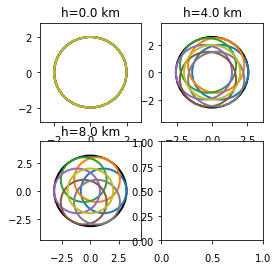

In [22]:
forward.plotPupils()

# Neural network approach
Our aim here is to describe a control system that computes the shape of the DMs to compensate for the largest amount of turbulence in the observing volume as possible. 

## Forward problem: how to compute detected wavefronts
The metapupil at height $j$ is written as a linear combination of $N$ Zernike modes as:
$$
MP_j = \sum_{i=1}^N \alpha_{ji} Z_{ji}(r)
$$
where the Zernike modes are defined in the complete metapupil. For this reason, the Zernike modes will be different for different heights (and it is indicated with the subindex $j$ in the Zernike modes). Likewise, the footprint of the telescope on each height and direction $k=1\ldots D$ can also be written as a Zernike expansion, in this case with a common Zernike basis with the size of the telescope pupil:
$$
FP_{jk} = \sum_{i=1}^N \beta_{kji} Z_{i}(r),
$$
where the coefficients $\beta_{kji}$ can be obtained from the coefficients $\alpha_{ji}$ by projecting it with the appropriate projection matrix (that depends on the height).

It is perhaps more clear if we order all observed wavefronts lexicographically and write everything in matrix form. The total accumulated wavefront observed at direction $k$ is given by:
$$
\boldsymbol{\phi}_k = \sum_{j=1}^H \mathbf{Z} \boldsymbol{\beta}_{kj}
$$
where $\boldsymbol{\beta}_{kj}$ are the Zernike coefficients of footprint along direction $k$ and height $j$. 
The matrix of Zernike modes is built by stacking all Zernike basis elements in lexicographic order (essentially flattening the 2D images of the Zernike modes and stacking them as columns of a matrix). These footprints can be written by a linear transformation of the Zernike modes of the metapupil, so that:
$$
\boldsymbol{\phi}_k = \sum_{j=1}^H \mathbf{Z} \mathbf{M}_{kj} \boldsymbol{\alpha}_{j}
$$

Now assume that there are a set of DMs conjugated only to a few heights of those for which we define the turbulence. The subset of indices is given by $A$, of length $N_D$. To formalize it, we use the indicator function with the set:
$$
\mathbb{1}_A(i) = 
\begin{cases} 
      1 & x \in A \\
      0 & x \notin A
   \end{cases}
$$

Therefore, including the DMs, the wavefront detected at each direction is given by (assuming that wavefronts are simply added linearly, which might break because one turbulent layer or DM affects the rays arriving to the next one):
$$
\boldsymbol{\phi}_k^\mathrm{corrected} = \sum_{j=1}^H \mathbf{Z} \left[ \mathbf{M}_{kj} \boldsymbol{\alpha}_{j} - \mathbb{1}_A(j) \mathbf{M}_{kj} \mathbf{d}_{j} \right],
$$
where $\mathbf{d}_{j}$ are the Zernike coefficients (coefficients computed on the metapupil) of the DM conjugated at height $j$. Precisely for the fact that the combination of wavefronts is linear, the ordering of DMs is irrelevant.

Further simplifying the expression, we find:
$$
\boldsymbol{\phi}_k^\mathrm{corrected} = \sum_{j=1}^H \mathbf{Z} \mathbf{M}_{kj} \left[ \boldsymbol{\alpha}_{j} - \mathbb{1}_A(j) \mathbf{d}_{j} \right].
$$
The corrected wavefront can also be written as:
$$
\boldsymbol{\phi}_k^\mathrm{corrected} = \boldsymbol{\phi}_k - \sum_{j=1}^H \mathbf{Z} \mathbf{M}_{kj} \mathbb{1}_A(j) \mathbf{d}_{j}.
$$

From the previous expression, one can extract the detected Zernike coefficients of the wavefront at direction $k$. They are given by the expression:
$$
\boldsymbol{\phi}_k = \mathbf{Z} \boldsymbol{\gamma}_k,
$$
so that

$$
\boldsymbol{\gamma}_k^\mathrm{corrected} = \sum_{j=1}^H \mathbf{M}_{kj} \left[ \boldsymbol{\alpha}_{j} - \mathbb{1}_A(j) \mathbf{d}_{j} \right].
$$
This constitutes a set of linear systems of equation which is fundamentally the one given above, but with the influence of the existing DMs:
$$
\left[ 
\begin{array}{c}
\gamma_1^\mathrm{k=1} \\
\gamma_2^\mathrm{k=1} \\
\vdots \\
\gamma_1^\mathrm{k=2} \\
\gamma_2^\mathrm{k=2} \\
\vdots \\
\gamma_1^\mathrm{k=K} \\
\gamma_2^\mathrm{k=K} \\
\end{array}
\right] = \left[
\begin{array}{cccc}
\left[ \mathbf{M}_\mathrm{j=1}^\mathrm{k=1}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{k=1}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{k=1}\right] & \cdots \\
\left[ \mathbf{M}_\mathrm{j=1}^\mathrm{k=1}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{k=1}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{k=1}\right] & \cdots \\
\cdots & \cdots & \cdots & \cdots \\
\left[ \mathbf{M}_\mathrm{j=1}^\mathrm{k=K}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{star K}\right] & \left[ \mathbf{M}_\mathrm{j=2}^\mathrm{k=K}\right] & \cdots 
\end{array}
\right]
\left[
\begin{array}{c}
a_1^\mathrm{j=1} - \mathbb{1}_A(j=1) d_1^\mathrm{j=1}\\
a_2^\mathrm{j=1} - \mathbb{1}_A(j=1) d_2^\mathrm{j=1} \\
\vdots \\
a_1^\mathrm{j=2} - \mathbb{1}_A(j=2) d_1^\mathrm{j=2} \\
a_2^\mathrm{j=2} - \mathbb{1}_A(j=2) d_2^\mathrm{j=2} \\
\vdots \\
a_1^\mathrm{j=H} - \mathbb{1}_A(j=H) d_1^\mathrm{j=H} \\
a_2^\mathrm{j=H} - \mathbb{1}_A(j=H) d_2^\mathrm{j=H} \\
\end{array}
\right].
$$

Additionally, the Zernike coefficients of the corrected wavefronts can also be written in terms of the uncorrected ones:
$$
\boldsymbol{\gamma}_k^\mathrm{corrected} = \boldsymbol{\gamma}_k - \sum_{j=1}^H \mathbf{M}_{kj} \mathbb{1}_A(j) \mathbf{d}_{j}.
$$

## Neural network
A neural network is proposed to control the DMs.

### Open loop
If working on open loop, where the WFS are detecting the turbulence of the atmosphere before passing through the DMs, one can propose a neural network that gets as input the images of the WFS (in fact of the Shack-Hartmann) and outputs directly the voltages of the DMs. For simplicity, let's discard for the moment the conversion from wavefront to voltages. Therefore, the training is done following the next scheme:

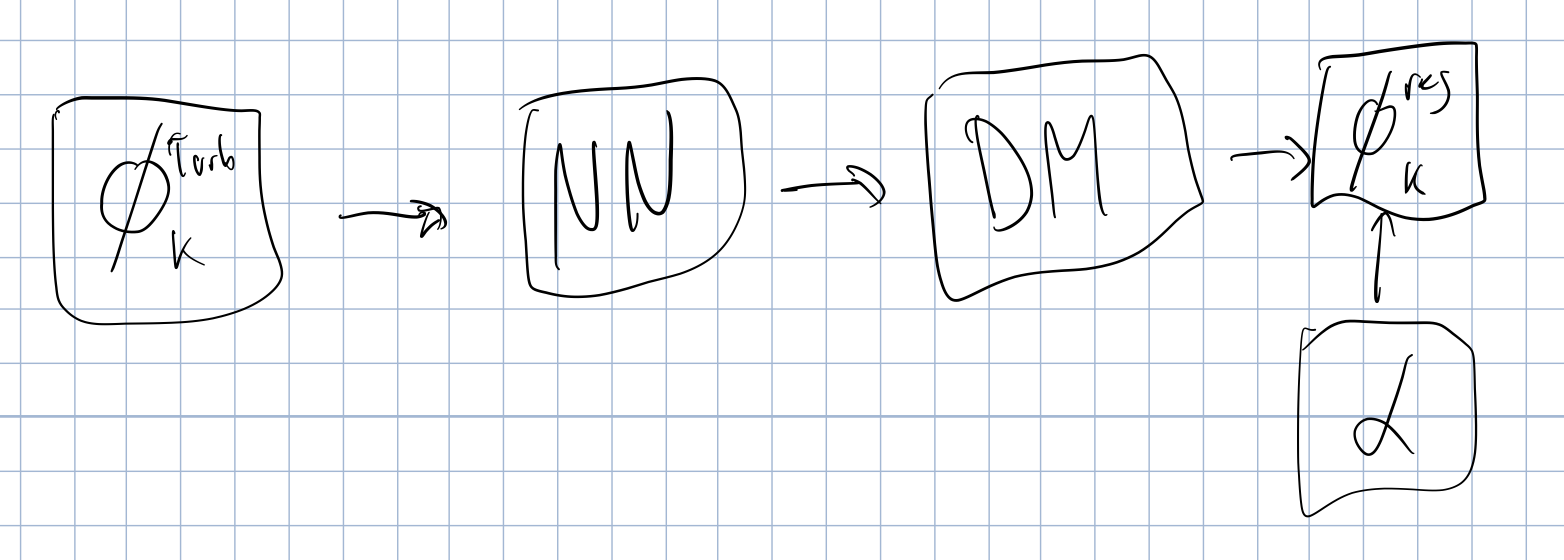

In [24]:
Image(filename="training.png")

Iterate:
1. Generate a realistic atmosphere by computing the $\boldsymbol{\alpha}$ Zernike coefficients for each metapupil, extracting them from an appropriate model. The easiest is to simply extract them following a Kolmogorov law with a certain Fried radius that changes with height. The more realistic way is to generate realistic phase screens at each height and move them with the typical wind. This second option has the advantage of producing changes in the atmosphere with the appropriate temporal coherence but I'm not sure to what extent this is crucial.
2. Propagate many synthetic solar images through the atmosphere so that synthetic images are generated at the SH.
3. The SH sensor measures the images of the FOV. These images, of size $N_\mathrm{SH} \times N_\mathrm{SH}$ are stacked as a tensor of dimension $C \times N_\mathrm{SH} \times N_\mathrm{SH}$, where $C$ refers to the number of subapertures in the SH detector.
4. A neural network gets this tensor as input and outputs a new tensor with the wavefront needed for each DM. The neural network is then a very flexible mapping which computes
$$
\mathbf{d} = f(\boldsymbol{\theta},\{\boldsymbol{\gamma}_k,k=1\ldots D\}),
$$
where $\boldsymbol{\theta}$ is the set of weights of the deep neural network. Since $N_D$ is the number of DMs, then the output tensor has dimensions $N_D \times N$, with $N$ the number of Zernike modes of each DM.
5. The equations in the previous section then allow us to compute the residual wavefront by combining the known $\boldsymbol{\alpha}$ and the shape of the DMs predicted by the neural network. This returns the Zernike coefficients of the residual wavefront, that we repeat for simplicity:
$$
\boldsymbol{\gamma}_k^\mathrm{corrected} = \sum_{j=1}^H \mathbf{M}_{kj} \left[ \boldsymbol{\alpha}_{j} - \mathbb{1}_A(j) \mathbf{d}_{j} \right].
$$
6. Finally, we compute the loss function as
$$
L = \sum_{k=1}^D \parallel \boldsymbol{\gamma}_k^\mathrm{corrected} \parallel^2
$$

### Closed loop
When the MCAO system is working in closed loop, the WFS is behind the DMs, so that one does not have access to the wavefront. The WFS are always sensing the residual wavefront. In this case, one needs to keep memory of the previous state of the atmosphere and the DMs so that it is possible then to train a neural network to compute how to tune the DMs to cancel the residual wavefront. We propose to train a neural network in open loop with simulations like in the previous step but using weak turbulence. This mimicks the presence of the DMs on the turbulence. Perhaps it would make sense to also include in the training strong turbulence as a consequence of residual turbulence in intermediate layers not corrected by the DMs.

Perhaps it is also possible to use a recurrent neural network for the control that takes into account the previous state of the atmosphere and DMs. However, this would require the simulation of realistic atmospheres with realistic changes in seeing.

## Reinforcement learning
Another possible way of solving this problem is via deep reinforcement learning, by defining a recurrent neural network. Some examples along this direction follows:

http://folk.ntnu.no/skoge/prost/proceedings/adconip-2017/media/files/0156.pdf

https://arxiv.org/pdf/1805.11835